In [1]:
import pandas as pd
import wandb

api = wandb.Api()

# Project is specified by <entity/project-name>
runs = api.runs("tunnels-ssl/05.10")

summary_list, config_list, name_list = [], [], []
for run in runs:
    # .summary contains the output keys/values for metrics like accuracy.
    #  We call ._json_dict to omit large files
    summary_list.append(run.summary._json_dict["test/avg_acc_tag"])

    # .config contains the hyperparameters.
    #  We remove special values that start with _.
    config_list.append({k: v for k, v in run.config.items() if not k.startswith("_")})

    # .name is the human-readable name of the run.
    name_list.append(run.name)

runs_df = pd.DataFrame(
    {"avg_acc_tag": summary_list, "config": config_list, "name": name_list}
)

config_df = pd.json_normalize(runs_df["config"])
df = pd.concat([runs_df.drop(columns=["config"]), config_df], axis=1)
df["data.datasets"] = df["data.datasets"].apply(lambda x: x[0])

In [34]:
from typing import Optional


layers = {
    "last_layer": ["fc", "classifier"],
    "intermediate": ["after_relu", "after_skipping"],
}


def get_df(
    df, network: str, layer: str, dataset: str, noreg_val: Optional[float] = None
):
    conditions = (
        (df["model.network"].str.contains(network))
        & (df["misc.seed"] == 0)
        & (df["data.datasets"].str.contains(dataset))
        & (df["training.approach.name"] == "finetuning")
        & (df["data.exemplars.num_exemplars"] == 0)
        & (df["data.nc_first_task"] != 50)
        & (df["data.stop_at_task"] == 3)
        & (df["data.num_tasks"] == 5)
    )
    varcov = conditions & (
        df["training.vcreg.reg_layers"].str.contains("|".join(layers[layer]))
    )

    if not noreg_val:
        noreg = conditions & (df["training.vcreg.reg_layers"].isna())
        noreg_val = df[noreg]["avg_acc_tag"].item()

    filtered_df = df[varcov]
    filtered_df["diff"] = filtered_df["avg_acc_tag"] - noreg_val
    return filtered_df
    # & (df["training.vcreg.reg_layers"].str)
    # filtered_df = df[
    # ]
    # )
    # noreg = filtered_df[filtered_df["training.vcreg.reg_layers"].isna()]

    # return filtered_df[varcov.dropna()] - noreg

In [35]:
network = "resnet"
p = get_df(df, network, "last_layer", "cifar").pivot(
    index="training.vcreg.var_weight",
    columns="training.vcreg.cov_weight",
    values="diff",
)
# Plot the heatmap on the current axis
# sns.heatmap(p, annot=True, ax=ax, vmin=-10, vmax=10)
# ax.set_title(" ".join([network, layer]))

Series([], Name: avg_acc_tag, dtype: float64)
48    14.333333
49     6.950000
50    22.300000
51    13.650000
52     5.700000
53     9.633333
54     7.233333
55     6.150000
57    23.466667
58    18.083333
59    31.666667
60    26.150000
61    20.650000
62    28.216667
63    28.733333
64    28.450000
Name: avg_acc_tag, dtype: float64


ValueError: can only convert an array of size 1 to a Python scalar

ValueError: can only convert an array of size 1 to a Python scalar

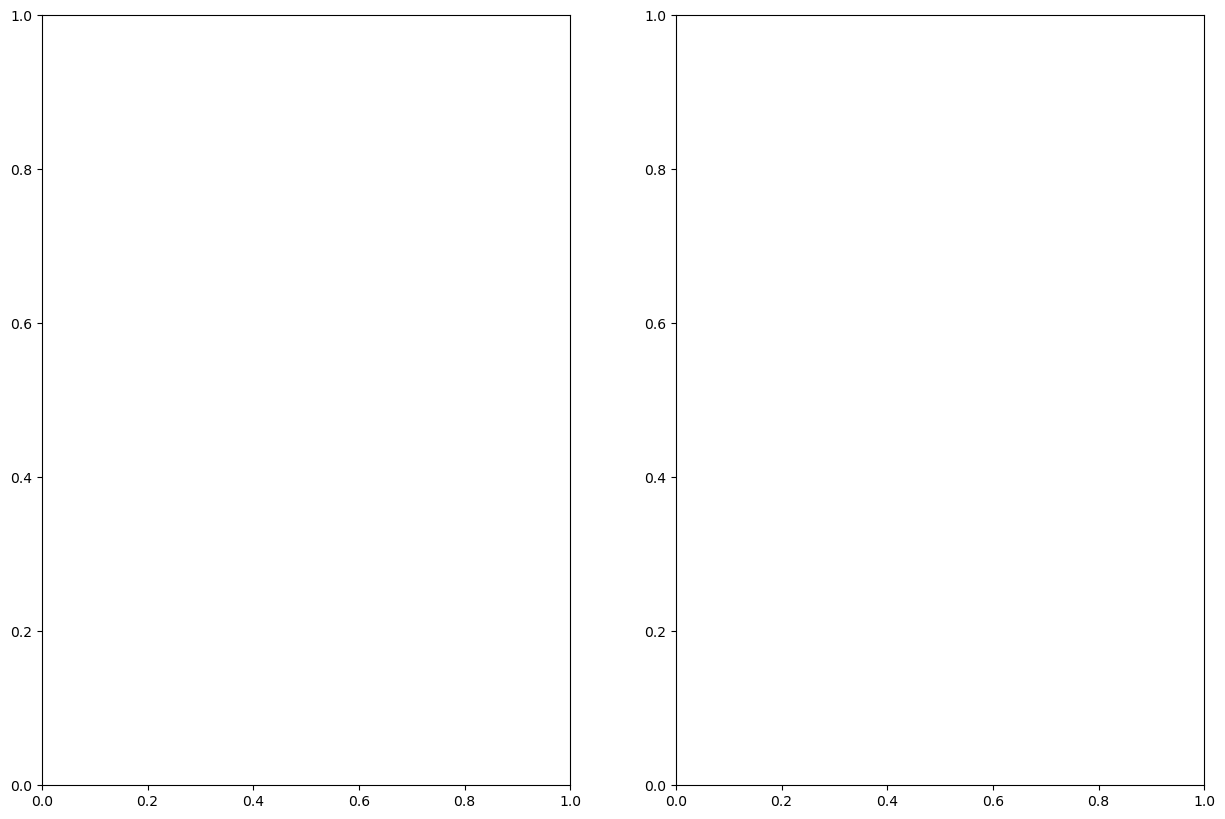

In [15]:
from itertools import product
from matplotlib import pyplot as plt
import seaborn as sns

# for network, layer in product(["resnet", "convnext"], ["last_layer", "intermediate"]):
#     p = get_df(df, network, layer).pivot(
#         index="training.vcreg.var_weight",
#         columns="training.vcreg.cov_weight",
#         values="avg_acc_tag",
#         # aggfunc=lambda x: list(x),
#     )
#     sns.heatmap(p, annot=True)
#     plt.title(" ".join([network, layer]))
#     plt.show()

networks = ["resnet", "convnext"]
n_rows = len(networks)
n_cols = len(layers)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))

axes = axes.flatten()

for ax, (network, layer) in zip(axes, product(networks, layers)):
    # Get the DataFrame for the specific network and layer

    p = get_df(df, network, layer, "cifar").pivot(
        index="training.vcreg.var_weight",
        columns="training.vcreg.cov_weight",
        values="diff",
    )
    # Plot the heatmap on the current axis
    sns.heatmap(p, annot=True, ax=ax, vmin=-10, vmax=10)
    ax.set_title(" ".join([network, layer]))

# Adjust layout
plt.tight_layout()
plt.show()